In [3]:
import os
import pandas as pd
import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut
from concurrent.futures import ProcessPoolExecutor
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
def fit_image(fname):
  
  
    dicom = pydicom.dcmread(fname)
    X = apply_voi_lut(dicom.pixel_array, dicom, prefer_lut = False)
        
    X = (X - X.min()) / (X.max() - X.min())
    
    if dicom.PhotometricInterpretation == "MONOCHROME1":
        X = 1 - X
    
    X = X * 255
    
    # Some images have narrow exterior "frames" that complicate selection of the main data. Cutting off the frame
    X = X[10:-10, 10:-10]
    
    # regions of non-empty pixels
    output= cv2.connectedComponentsWithStats((X > 20).astype(np.uint8), 8, cv2.CV_32S)

    # stats.shape == (N, 5), where N is the number of regions, 5 dimensions correspond to:
    # left, top, width, height, area_size
    stats = output[2]
    
    # finding max area which always corresponds to the breast data. 
    idx = stats[1:, 4].argmax() + 1
    x1, y1, w, h = stats[idx][:4]
    x2 = x1 + w
    y2 = y1 + h
    
    # cutting out the breast data
    X_fit = X[y1: y2, x1: x2]
    
    study_id, im_id = fname.split("/")[-2], fname.split("/")[-1][:-6]
        
    os.makedirs(f'/kaggle/working/Processed_Images/{study_id}', exist_ok=True)
    cv2.imwrite(f'/kaggle/working/Processed_Images/{study_id}/{im_id}.png', X_fit)
    
def fit_all_images(all_images):
    with ProcessPoolExecutor(4) as p:
        for i, _ in enumerate(p.map(fit_image, all_images)):
            if (i % 100 == 0):
                print(i, 'images processed!')

In [5]:
dicom = pydicom.dcmread('data/test1/dcm/d88d4b9103281220b9ac1a122364973b.dicom')

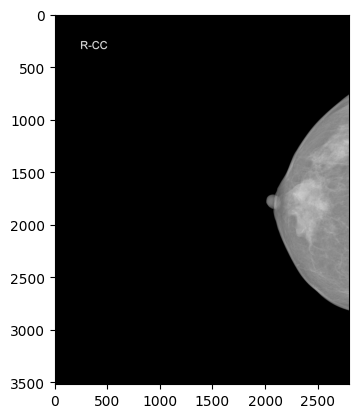

In [6]:
arr = dicom.pixel_array
plt.imshow(arr, 'gray')

(np.float64(-0.5), np.float64(2799.5), np.float64(3517.5), np.float64(-0.5))

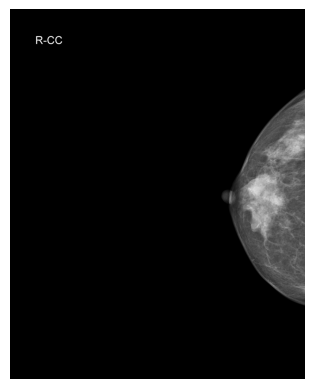

In [7]:
arr = apply_voi_lut(dicom.pixel_array, dicom)
plt.imshow(arr, 'gray')
plt.axis('off')

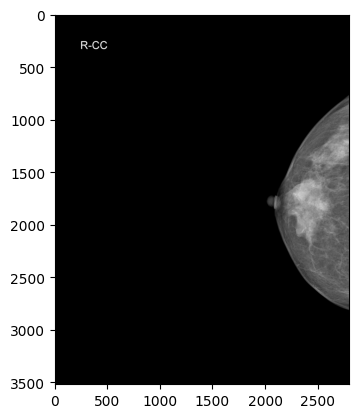

In [47]:
arr = apply_voi_lut(dicom.pixel_array, dicom, prefer_lut=False)
plt.imshow(arr, 'gray')

In [8]:
findings = pd.read_csv('/Users/julio/physionet.org/files/vindr-mammo/1.0.0/finding_annotations.csv')
findings.loc[findings['study_id'] == '0cc015fba720993209f0b8843ff98699']

,study_id,series_id,image_id,laterality,view_position,height,width,breast_birads,breast_density,finding_categories,finding_birads,xmin,ymin,xmax,ymax,split
671,0cc015fba720993209f0b8843ff98699,bb22c5a752fc07b28d17f18c4604ae5e,d88d4b9103281220b9ac1a122364973b,R,CC,3518,2800,BI-RADS 4,DENSITY C,['Mass'],BI-RADS 4,2455.840088,1748.599976,2609.159912,1878.819946,training
672,0cc015fba720993209f0b8843ff98699,bb22c5a752fc07b28d17f18c4604ae5e,d88d4b9103281220b9ac1a122364973b,R,CC,3518,2800,BI-RADS 4,DENSITY C,['Mass'],BI-RADS 4,2243.340088,1657.560059,2410.989990,1789.949951,training
673,0cc015fba720993209f0b8843ff98699,bb22c5a752fc07b28d17f18c4604ae5e,1297fb4b53170324f0f6eeaf74c4449c,R,MLO,3518,2800,BI-RADS 4,DENSITY C,['Mass'],BI-RADS 4,2143.600098,1226.219971,2286.560059,1349.430054,training
674,0cc015fba720993209f0b8843ff98699,bb22c5a752fc07b28d17f18c4604ae5e,1297fb4b53170324f0f6eeaf74c4449c,R,MLO,3518,2800,BI-RADS 4,DENSITY C,['Mass'],BI-RADS 4,2278.750000,1504.810059,2393.500000,1626.939941,training
11525,0cc015fba720993209f0b8843ff98699,bb22c5a752fc07b28d17f18c4604ae5e,71b862ab0072c6ced66f41253169abd0,L,CC,3518,2800,BI-RADS 1,DENSITY C,['No Finding'],NaN,NaN,NaN,NaN,NaN,training
11526,0cc015fba720993209f0b8843ff98699,bb22c5a752fc07b28d17f18c4604ae5e,281a8bb91504e713b7e68ab6c8f4ebe7,L,MLO,3518,2800,BI-RADS 1,DENSITY C,['No Finding'],NaN,NaN,NaN,NaN,NaN,training


In [9]:
test_df = pd.DataFrame(columns=findings.columns)
test_df.loc[0] = findings.loc[671].copy()
test_df.loc[1] = findings.loc[672].copy()
test_df.loc[2] = findings.loc[673].copy()
test_df.loc[3] = findings.loc[674].copy()

(np.float64(-0.5), np.float64(2799.5), np.float64(3517.5), np.float64(-0.5))

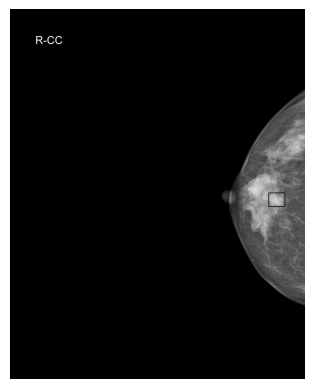

In [10]:
point1 = tuple(test_df.loc[0][['xmin', 'ymin']])
# Convertir los valores de np.float64 a float
point1 = tuple(int(x) for x in point1)

point2 = tuple(test_df.loc[0][['xmax', 'ymax']])

point2= tuple(int(x) for x in point2)

color = (0, 255, 0)
thickness = 5
image = cv2.rectangle(arr, point1, point2, color, thickness)
plt.imshow(image, 'gray')
plt.axis('off')

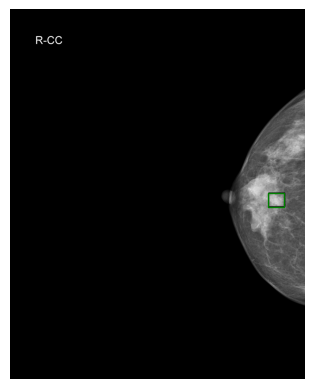

In [12]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Supongamos que 'arr' es la imagen original en escala de grises o color

# Definir los puntos del rectángulo
point1 = tuple(int(x) for x in test_df.loc[0][['xmin', 'ymin']])
point2 = tuple(int(x) for x in test_df.loc[0][['xmax', 'ymax']])

# Calcular ancho y alto del rectángulo
rect_width = point2[0] - point1[0]
rect_height = point2[1] - point1[1]

#point3 = tuple(int(x) for x in test_df.loc[1][['xmin', 'ymin']])
#point4 = tuple(int(x) for x in test_df.loc[1][['xmax', 'ymax']])
# Calcular ancho y alto del rectángulo
#rect_width2 = point4[0] - point3[0]
#rect_height2 = point4[1] - point3[1]


# Crear la figura y los ejes
fig, ax = plt.subplots()

# Mostrar la imagen
ax.imshow(arr, cmap='gray')

# Crear un rectángulo con los puntos calculados y agregarlo a la imagen
rect = patches.Rectangle(point1, rect_width, rect_height, linewidth=1, edgecolor='g', facecolor='none')
ax.add_patch(rect)

#rect = patches.Rectangle(point3, rect_width2, rect_height2, linewidth=1, edgecolor='g', facecolor='none')
#ax.add_patch(rect)

# Mostrar la imagen con el rectángulo
plt.axis('off')
plt.show()
